In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
import re
import nltk
import nltk.sentiment
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare
import wrangle

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from random import sample
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('npr_corpus.csv')
df.head()

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped
0,0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,it s a 2200 mile race. to give some sense of p...,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...
1,1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...
2,2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so in every team presumably there s one star o...,so in every team presumably there s one star o...,every team presumably one star one equivalent ...
3,3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,right. team ha nine riders. basically team lea...
4,4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so slipstream this is like drafting in car rac...,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?


In [3]:
df['date'] = pd.to_datetime(df.episode_date)
df['year'] = pd.DatetimeIndex(df['date']).year

In [4]:
df.speaker.value_counts().head()

NEAL CONAN, host       204935
IRA FLATOW, host        58172
NEAL CONAN, HOST        43469
FARAI CHIDEYA, host     36462
STEVE INSKEEP, HOST     31549
Name: speaker, dtype: int64

In [5]:
is_hosts_df = df[df.is_host == True]
is_hosts_df.head()

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped,date,year
2,2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so in every team presumably there s one star o...,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,2010-07-12,2010
4,4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so slipstream this is like drafting in car rac...,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,2010-07-12,2010
6,6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,and so the guy who s in back has an easier tim...,and so the guy who s in back ha an easier time...,guy back ha easier time. even people front bre...,2010-07-12,2010
8,8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,we re talking with loren mooney the editor in ...,we re talking with loren mooney the editor in ...,talking loren mooney editor chief bicycling ma...,2010-07-12,2010
10,10,57264,19,"NEAL CONAN, host","Hi, John.",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,hi john .,hi john .,hi john .,2010-07-12,2010


In [6]:
df.dtypes

Unnamed: 0                     int64
episode_id                     int64
episode_order                  int64
speaker                       object
utterance                     object
program                       object
title                         object
episode_date                  object
is_host                         bool
clean                         object
lemmatized                    object
lemmatized_stopped            object
date                  datetime64[ns]
year                           int64
dtype: object

In [7]:
df.isnull().sum()

Unnamed: 0              0
episode_id              0
episode_order           0
speaker                 0
utterance               0
program                 0
title                   0
episode_date            0
is_host                 0
clean                   3
lemmatized              3
lemmatized_stopped    134
date                    0
year                    0
dtype: int64

In [8]:
df.dropna(inplace = True)
df.isnull().sum()

Unnamed: 0            0
episode_id            0
episode_order         0
speaker               0
utterance             0
program               0
title                 0
episode_date          0
is_host               0
clean                 0
lemmatized            0
lemmatized_stopped    0
date                  0
year                  0
dtype: int64

### WordClouds

- Data goes from the years 1999 - 2019
- I am excluding the years 1999 - 2005. 1999 is fine, but 2001 - 2004 either have little/no values.

In [9]:
train, validate, test = wrangle.split_data(df)

In [10]:
def string_cleaning(s):
    '''
    Function to remove punctuation and numbers from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z'\s]", '', s)

    return s

In [11]:
stopwords = pd.read_excel('stop_words_df.xlsx')
stopwords = stopwords.words.to_list()

In [12]:
train

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped,date,year
315659,337896,31875,2,"FARAI CHIDEYA, host","America is, quote, ""living a nightmare with no...",News & Notes,Top General Refuels Debate Over Iraq,2007-10-16,True,america is quote living a nightmare with no en...,america is quote living a nightmare with no en...,america quote living nightmare end sight. acco...,2007-10-16,2007
2353618,2513965,139452,15,Mr. JAKE GYLLENHAAL,(As Anthony Swofford) Yeah.,All Things Considered,'Jarhead' and the Attraction of War,2005-11-05,False,as anthony swofford yeah .,a anthony swofford yeah .,anthony swofford yeah .,2005-11-05,2005
2536307,2707959,116782,6,JACOB FENSTON,So I actually have to get a physical card?,All Things Considered,Mobile Payments Challenge Credit Cards,2011-02-21,False,so i actually have to get a physical card ?,so i actually have to get a physical card ?,actually get physical card ?,2011-02-21,2011
1765863,1889237,97255,1,"ARUN RATH, HOST","The new show ""Gotham"" has been a hit - lots of...",All Things Considered,'Gotham' Resurfaces Hollywood's Tricky History...,2014-10-26,False,the new show gotham has been a hit lots of lov...,the new show gotham ha been a hit lot of love ...,new show gotham ha hit lot love critic audienc...,2014-10-26,2014
760662,813122,33848,57,JUAN JOSE VALDES,"...you know, where is that? Miami. Luckily eno...",Talk of the Nation,"Cartographer Maps Cuba, And A Personal History",2011-09-20,False,... you know where is that ? miami. luckily en...,... you know where is that ? miami. luckily en...,... know ? miami. luckily enough lived across ...,2011-09-20,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822545,3012432,76840,60,Mr. GEORGE MITCHELL (Former Democratic Senator...,A lot of members have been elected to the Sena...,Talk of the Nation,Former Senators Talk About Finding Common Ground,2007-01-23,False,a lot of members have been elected to the sena...,a lot of member have been elected to the senat...,lot member elected senate house rather adaptin...,2007-01-23,2007
2682223,2863053,32950,39,PAUL KEIM,"They, you know, there was this accusation that...",Talk of the Nation,Scientific Case Still Open On 2001 Anthrax Att...,2011-10-28,False,they you know there was this accusation that t...,they you know there wa this accusation that th...,know wa accusation spanish cucumber example so...,2011-10-28,2011
1183606,1270418,10126,7,"SCOTT SIMON, HOST",Right.,Weekend Edition Saturday,Nate Silver On Missed UK Forecasts: We Flubbed...,2015-05-09,False,right .,right .,right .,2015-05-09,2015
1469875,1574804,87477,1,"RENEE MONTAGNE, HOST",Scientists say they've genetically engineered ...,Morning Edition,Engineers Make Narcotics With Yeast. Is Home-B...,2015-08-14,False,scientists say they ve genetically engineered ...,scientist say they ve genetically engineered y...,scientist say genetically engineered yeast mak...,2015-08-14,2015


In [13]:
# aggregate utterances
bush_words = train[train.year.isin([2005, 2006, 2007, 2008, 2009])].groupby('year')['clean'].agg(lambda col: ' '.join(col))

obama_words = train[train.year.isin([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2017])].groupby('year')['clean'].agg(lambda col: ' '.join(col))


trump_words = train[train.year.isin([2017, 2018, 2019])].groupby('year')['clean'].agg(lambda col: ' '.join(col))

In [15]:
bush_words = bush_words.apply(string_cleaning).apply(prepare.remove_stopwords, extra_words = stopwords)

obama_words = obama_words.apply(string_cleaning).apply(prepare.remove_stopwords, extra_words = stopwords)

trump_words = trump_words.apply(string_cleaning).apply(prepare.remove_stopwords, extra_words = stopwords)

In [16]:
bush_words

year
2005    anthony swofford translator change matter gene...
2006    walter leave walter fields ceo publisher north...
2007    america quote living nightmare end sight accor...
2008    good martha thank wondering turnout south caro...
2009    karzai newest best friend senator john kerry s...
Name: clean, dtype: object

In [17]:
# create word frequencies
bush_freq = pd.Series(bush_words.str.split().value_counts())
obama_freq = pd.Series(obama_words.str.split().value_counts())
trump_freq = pd.Series(trump_words.str.split().value_counts())

In [18]:
# create dictionary for word clouds
word_lists = {'George W. Bush (Served: 2001 - 2009)': bush_words, 
'Barack Obama (Served: 2009 - 2017)': obama_words, 
'Donald J. Trump (Served: 2017 - 2021)': trump_words}

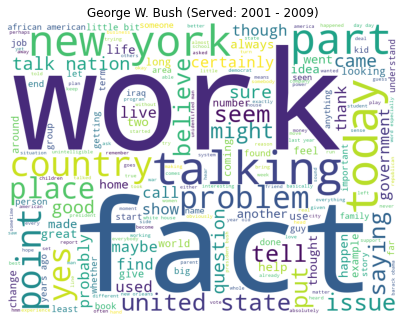

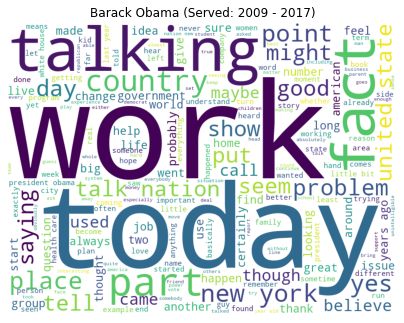

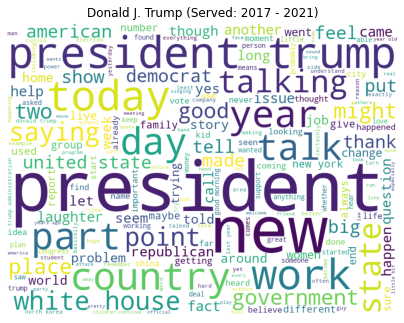

In [19]:
# word clouds
for h in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(' '.join(word_lists[h]))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

In [ ]:
# obtain top 10 hosts
hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# create host df
hosts_df = df[df.speaker.isin(hosts_to_keep)]
# get episode_id of top 10 hosts
top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()

In [ ]:
# top 10 hosts
hosts_df.speaker.value_counts().head(10).index.to_list()